# Introduction

Welcome to this lab!
At this lab, we will learn how to implement Graph Convolutional Networks (GCN) based on the paper [GCN](https://arxiv.org/pdf/1609.02907.pdf).

The code is relatively straightforward to follow then comments will not be necessary. The main code we need to focus on is the class GCN_layer and class GCN.

# Exercise

## Download data and install packages

In [1]:
!gdown --id "1Z748ksOFWZ8WLsy0P8T7eYA6XLVLieX3&export=download"
!unrar x -Y "/content/lab2.rar" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1Z748ksOFWZ8WLsy0P8T7eYA6XLVLieX3&export=download
To: /content/lab2.rar
100% 599/599 [00:00<00:00, 1.65MB/s]

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/lab2.rar

Extracting  /content/lab2_edgelist.txt                                    55%  OK 
Extracting  /content/lab2_attributes.csv                                  89%  OK 
All OK


## Packages: Import neccesary packages

In [2]:
import torch
import torch.nn as nn
import numpy as np
import networkx as nx
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd

## Utils: Processing data

In [3]:
def create_graphs_with_attributes(edgelist_filepath,attributes_filepath):
    graph=nx.read_edgelist(edgelist_filepath,nodetype=int)
    attributes=pd.read_csv(attributes_filepath,index_col=['node'])
    att_values = {a:{'role':b[0],'community':b[1]} for a,b in enumerate(attributes.values)}
    nx.set_node_attributes(graph,att_values)
    return graph


def create_train_test(graph):
    X_train,Y_train,X_test,Y_test=[],[],[],[]
    for node, data in graph.nodes(data=True):
        if data['role'] in ['Administrator','Instructor']:
            X_train.append(node)
            Y_train.append(data['role']=='Administrator')
        elif data['role'] =='Member':
            X_test.append(node)
            Y_test.append(data['community']=='Administrator')
    return np.asarray(X_train),np.asarray(Y_train),np.asarray(X_test),np.asarray(Y_test)



def create_features(graph): # create input features, concatenation of identity matrix and shortest paths to targets
    A = nx.to_numpy_matrix(graph)
    X_1 = torch.eye(A.shape[0]) # identity matrix
    X_2 = torch.zeros((A.shape[0], 2)) # shortest path to the targets as 2nd input feature
    node_distance_instructor = nx.shortest_path_length(graph, target=33)
    node_distance_administrator = nx.shortest_path_length(graph, target=0)

    for node in graph.nodes():
        X_2[node][0] = node_distance_administrator[node]
        X_2[node][1] = node_distance_instructor[node]

    return torch.cat((X_1,X_2),dim=1)    

## Model: Graph Convolutional Networks

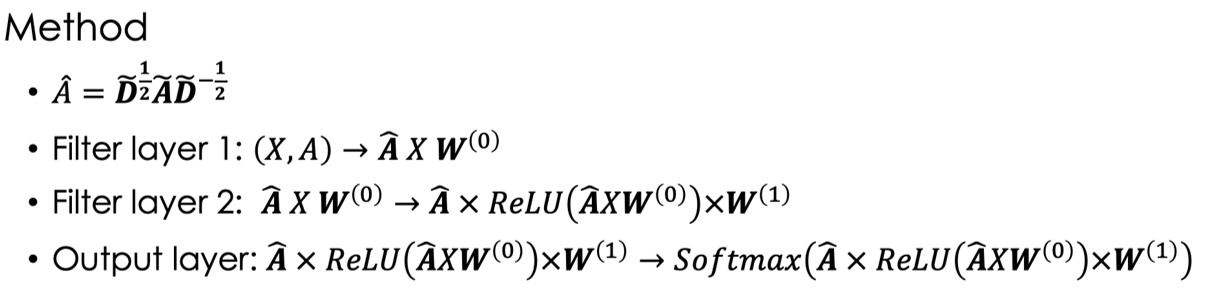

In [4]:
from torch.nn.parameter import Parameter

class GCN_layer(nn.Module):
    """
      Define filter layer 1/2 like in the above image
      Calculate A_hat first then,
      Input: adj_matrix with input features X
    """   

    def __init__(self, inputs_shape, outputs_shape):
        super(GCN_layer, self).__init__()

        self.W=Parameter(torch.rand(inputs_shape,outputs_shape),requires_grad=True)
        self.bias = Parameter(torch.rand(outputs_shape),requires_grad=True)

    
    def forward(self, adj_matrix, input_features):
        A=torch.from_numpy(adj_matrix).type(torch.LongTensor)
        I=torch.eye(A.shape[0])   
        A_hat=A+I        
        D=torch.sum(A_hat,axis=0)        
        D=torch.diag(D)       
        D_inv=torch.inverse(D)              
        A_hat = torch.mm(torch.mm(D_inv,A_hat),D_inv)     
        aggregate=torch.mm(A_hat,input_features)      
        propagate=torch.mm(aggregate,self.W)+self.bias             
        return propagate

In [5]:
class GCN(nn.Module):
    

    def __init__(self,inputs_shape,outputs_shape,n_classes,activation='Relu'):
        super(GCN, self).__init__()

        self.layer1=GCN_layer(inputs_shape,outputs_shape)
        self.layer2=GCN_layer(outputs_shape,n_classes)
        
        
        if activation =='Tanh':
            self.activation = nn.Tanh()
        elif activation=='Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation=='Softmax':
            self.activation=nn.Softmax()
        elif activation=='Relu':
            self.activation=nn.ReLU()
    
        self.softmax=nn.Softmax()
        
    
    def forward(self,adj_matrix,input_features):
        
        x=self.layer1(adj_matrix,input_features)
        x=self.activation(x) 
        x=self.layer2(adj_matrix,x)
        x=self.softmax(x)     
        
        return x

In [6]:
import torch
from sklearn.metrics import classification_report
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import networkx as nx


graph=create_graphs_with_attributes('lab2_edgelist.txt','lab2_attributes.csv')
A = np.array(nx.to_numpy_matrix(graph)) # adjadjency matrix

class Trainer():
    def __init__(self,model,optimizer,loss_function,epochs):
        
        self.model=model
        self.optimizer=optimizer
        self.loss_function=loss_function
        self.epochs=epochs
        
    def train(self,X_train,Y_train):

        y_train=torch.from_numpy(Y_train.astype(int)).type(torch.LongTensor)
        tot_loss=0.0
        all_preds=[]

        for t in range(self.epochs):
            epoch_loss = 0.0

            #model.train()
            y_pred=self.model(A, create_features(graph))
            all_preds.append(y_pred)
            loss = self.loss_function(y_pred[X_train], y_train)
            self.optimizer.zero_grad()
            epoch_loss+=loss
            tot_loss+=loss
            loss.backward()
            self.optimizer.step()

            print(str(t),'epoch_loss:'+str(epoch_loss),'total loss:'+str(tot_loss))

        self.all_preds=all_preds
    
    def test(self,X_test,Y_test):

        self.model.eval()
        y_test=torch.from_numpy(Y_test.astype(int)).type(torch.LongTensor)
        y_pred=self.all_preds[-1]  # preds of last epoch
        loss_test = self.loss_function(y_pred[X_test],y_test)
        print('validation loss is equal to: '+str(loss_test))
    
    def visualize_classification(self,graph,Y_test,classification):
        last_epoch = self.all_preds[self.epochs-1].detach().numpy() # get outputs of last epoch
        predicted_class = np.argmax(last_epoch, axis=-1) # take the unit with the higher probability
        color = np.where(predicted_class==0, 'c', 'r')
        pos = nx.kamada_kawai_layout(graph)
        nx.draw_networkx(graph, pos, node_color=color, with_labels=True, node_size=300)
        if classification==True:
            print(classification_report(predicted_class[1:-1],Y_test))

## Run GCN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 epoch_loss:tensor(0.7081, grad_fn=<AddBackward0>) total loss:tensor(0.7081, grad_fn=<AddBackward0>)
1 epoch_loss:tensor(0.7062, grad_fn=<AddBackward0>) total loss:tensor(1.4143, grad_fn=<AddBackward0>)
2 epoch_loss:tensor(0.7043, grad_fn=<AddBackward0>) total loss:tensor(2.1186, grad_fn=<AddBackward0>)
3 epoch_loss:tensor(0.7025, grad_fn=<AddBackward0>) total loss:tensor(2.8211, grad_fn=<AddBackward0>)
4 epoch_loss:tensor(0.7007, grad_fn=<AddBackward0>) total loss:tensor(3.5218, grad_fn=<AddBackward0>)
5 epoch_loss:tensor(0.6990, grad_fn=<AddBackward0>) total loss:tensor(4.2208, grad_fn=<AddBackward0>)
6 epoch_loss:tensor(0.6973, grad_fn=<AddBackward0>) total loss:tensor(4.9181, grad_fn=<AddBackward0>)
7 epoch_loss:tensor(0.6957, grad_fn=<AddBackward0>) total loss:tensor(5.6139, grad_fn=<AddBackward0>)
8 epoch_loss:tensor(0.6942, grad_fn=<AddBackward0>) total loss:tensor(6.3080, grad_fn=<AddBackward0>)
9 epoch_loss:tensor(0.6926, grad_fn=<AddBackward0>) total loss:tensor(7.0007, grad

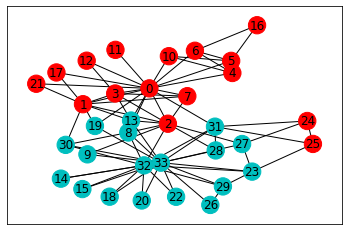

In [7]:
graph=create_graphs_with_attributes('lab2_edgelist.txt','lab2_attributes.csv')
A = np.array(nx.to_numpy_matrix(graph)) # adjadjency matrix
X_train,Y_train,X_test,Y_test= create_train_test(graph)

model=GCN(inputs_shape=create_features(graph).shape[1],outputs_shape=4,n_classes=2,activation='Relu')
trainer = Trainer(
    model,
    optimizer = optim.Adam(model.parameters(), lr=0.01),
    loss_function=F.cross_entropy,
    epochs=250
)

trainer.train(X_train,Y_train)
trainer.test(X_test,Y_test)
trainer.visualize_classification(graph,Y_test,classification=True)